Credits: https://github.com/Holmes-Alan/SIFT_ImgMatch/blob/main

Load required library

In [146]:
import cv2
import pickle
import matplotlib.pyplot as plt

In [147]:
# Resize images to a similar dimension
# This helps improve accuracy and decreases unnecessarily high number of keypoints

def imageResizeTrain(image):
    maxD = 1024
    height,width = image.shape
    aspectRatio = width/height
    if aspectRatio < 1:
        newSize = (int(maxD*aspectRatio),maxD)
    else:
        newSize = (maxD,int(maxD/aspectRatio))
    image = cv2.resize(image,newSize)
    return image

def imageResizeTest(image):
    maxD = 1024
    height,width,channel = image.shape
    aspectRatio = width/height
    if aspectRatio < 1:
        newSize = (int(maxD*aspectRatio),maxD)
    else:
        newSize = (maxD,int(maxD/aspectRatio))
    image = cv2.resize(image,newSize)
    return image

In [148]:
# Define a list of images you want to test

imageList = ["book1.jpg", "book2.jpg", "eiffel.jpg", "superman.jpg"]



In [149]:
# We use grayscale images for generating keypoints
imagesBW = []
for imageName in imageList:
    imagePath = str(imageName)
    imagesBW.append(imageResizeTrain(cv2.imread(imagePath,0))) # flag 0 means grayscale

In [150]:
# Using opencv's sift implementation here

sift = cv2.SIFT_create()

def computeSIFT(image):
    return sift.detectAndCompute(image, None)

In [151]:
keypoints = []
descriptors = []
for i,image in enumerate(imagesBW):
    print("Starting for image: " + imageList[i])
    if imageList[i] == "book1.jpg":
        print("  Skipping image: " + imageList[i])
    keypointTemp, descriptorTemp = computeSIFT(image)
    keypoints.append(keypointTemp)
    descriptors.append(descriptorTemp)
    print("  Ending for image: " + imageList[i])

Starting for image: book1.jpg
  Skipping image: book1.jpg
  Ending for image: book1.jpg
Starting for image: book2.jpg
  Ending for image: book2.jpg
Starting for image: eiffel.jpg
  Ending for image: eiffel.jpg
Starting for image: superman.jpg
  Ending for image: superman.jpg


In [152]:
for i, keypoint in enumerate(keypoints):
    deserializedKeypoints = []
    filepath = str(imageList[i].split('.')[0]) + "_kps.txt"
    for point in keypoint:
        temp = (point.pt, point.size, point.angle, point.response, point.octave, point.class_id)
        deserializedKeypoints.append(temp)
    with open(filepath, 'wb') as fp:
        pickle.dump(deserializedKeypoints, fp)

In [153]:
for i,descriptor in enumerate(descriptors):
    filepath = str(imageList[i].split('.')[0]) + "_feat.txt"
    with open(filepath, 'wb') as fp:
        pickle.dump(descriptor, fp)

**Task 1:** Define a reasonable threshold for the similarity between two image-keypoints

In [154]:
threshold = 0.8
def FilterMatches(matches, mode='selection'):
    '''
        Implements different options to filter matches.
            - 'sort' will simply sort them by similarity distance.
            - 'ratio' will employ the ratio test as in Lowe's paper
    '''
    if(mode == 'sort'):
        selection = sorted(matches, key = lambda x:x[0].distance)
    if(mode == 'ratio'):
        selection = [[m] for m, n in matches if m.distance < threshold*n.distance]

    return selection

Fetch Keypoints and Descriptors from stored files

In [155]:
def fetchKeypointFromFile(i):
    filepath = str(imageList[i].split('.')[0]) + "_kps.txt"
    keypoint = []
    file = open(filepath,'rb')
    deserializedKeypoints = pickle.load(file)
    file.close()
    for point in deserializedKeypoints:
        temp = cv2.KeyPoint(
            x=point[0][0],
            y=point[0][1],
            size=point[1],
            angle=point[2],
            response=point[3],
            octave=point[4],
            class_id=point[5]
        )
        keypoint.append(temp)
    return keypoint

def fetchDescriptorFromFile(i):
    filepath = str(imageList[i].split('.')[0]) + "_feat.txt"
    file = open(filepath,'rb')
    descriptor = pickle.load(file)
    file.close()
    return descriptor

In [156]:
# Calculate Results for any pair
bf = cv2.BFMatcher()
def calculateMatches(des1,des2):
    matches = bf.knnMatch(des1,des2,k=2)
    """
    for m,n in matches:
        if m.distance < 0.8*n.distance:
            topResults1.append([m])
    """
    topResults1 = FilterMatches(matches, mode='ratio')
    matches = bf.knnMatch(des2,des1,k=2)
    topResults2 = FilterMatches(matches, mode='ratio')
    '''
    for m,n in matches:
        if m.distance < 0.8*n.distance:
            topResults2.append([m])
    '''
    topResults = []
    for match1 in topResults1:
        match1QueryIndex = match1[0].queryIdx
        match1TrainIndex = match1[0].trainIdx

        for match2 in topResults2:
            match2QueryIndex = match2[0].queryIdx
            match2TrainIndex = match2[0].trainIdx

            if (match1QueryIndex == match2TrainIndex) and (match1TrainIndex == match2QueryIndex):
                topResults.append(match1)
    return topResults

# scoring metric, a score greater than 10 means very good
def calculateScore(matches,keypoint1,keypoint2):
    return 100 * (matches/min(keypoint1,keypoint2))

# draw KNN matching plot
def getPlot(image1,image2,keypoint1,keypoint2,matches):
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    matchPlot = cv2.drawMatchesKnn(
        image1,
        keypoint1,
        image2,
        keypoint2,
        matches,
        None,
        matchColor=[255, 0, 0],
        singlePointColor=[0, 255, 0],
        flags=0
    )
    return matchPlot

def getPlotFor(i,j,keypoint1,keypoint2,matches):
    image1 = imageResizeTest(cv2.imread(imageList[i]))
    image2 = imageResizeTest(cv2.imread(imageList[j]))
    return getPlot(image1,image2,keypoint1,keypoint2,matches)

# calculate matching results for any two images
def calculateResultsFor(i,j):
    keypoint1 = fetchKeypointFromFile(i)
    descriptor1 = fetchDescriptorFromFile(i)
    keypoint2 = fetchKeypointFromFile(j)
    descriptor2 = fetchDescriptorFromFile(j)
    matches = calculateMatches(descriptor1, descriptor2)
    score = calculateScore(len(matches),len(keypoint1),len(keypoint2))
    plot = getPlotFor(i,j,keypoint1,keypoint2,matches)
    print(f"Match paires: {len(matches)}, Keypoints in img1: {len(keypoint1)}, Keypoints in img2: {len(keypoint2)}")
    print(f"Matching score is: {score}%")
    plt.imshow(plot),plt.show()

Calculate the SIFT matches between images

Match paires: 26, Keypoints in img1: 2236, Keypoints in img2: 1620
Matching score is: 1.6049382716049383%


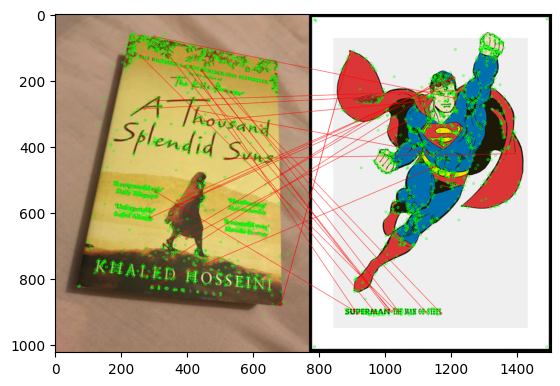

In [157]:
calculateResultsFor(0, 3) # calculate results for image 1 and image 4 (book1 and superman)
# Add tests between each image pair

**Task 2:** Redo the SIFT with all the images (including the 'book1_masked')

5 images were loaded successfully.
Match paires: 342, Keypoints in img1: 2236, Keypoints in img2: 2342
Matching score is: 15.30%


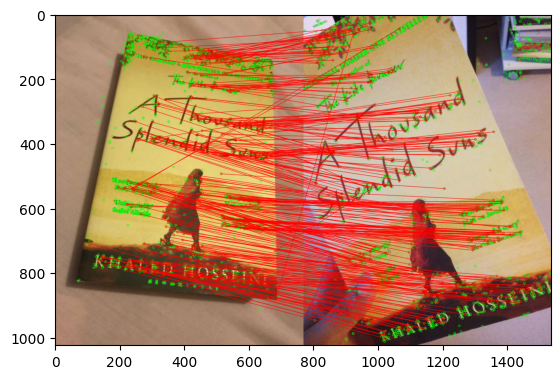

Match paires: 12, Keypoints in img1: 2236, Keypoints in img2: 1910
Matching score is: 0.63%


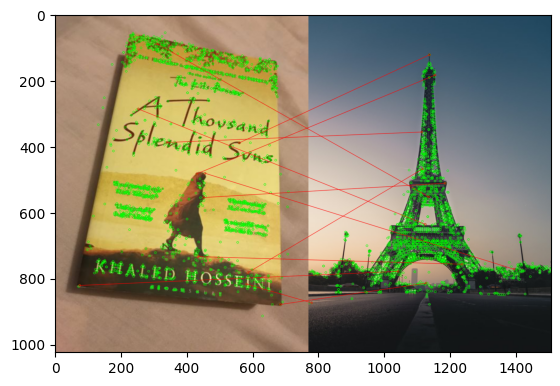

Match paires: 26, Keypoints in img1: 2236, Keypoints in img2: 1620
Matching score is: 1.60%


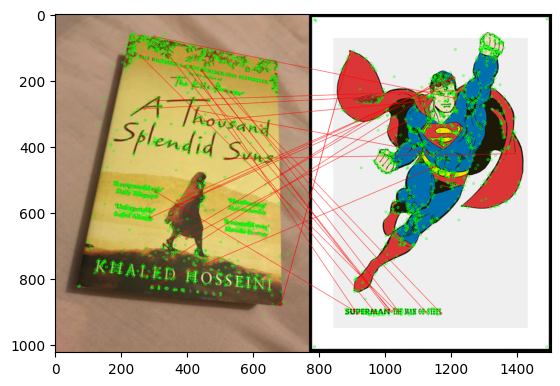

Match paires: 783, Keypoints in img1: 2236, Keypoints in img2: 3131
Matching score is: 35.02%


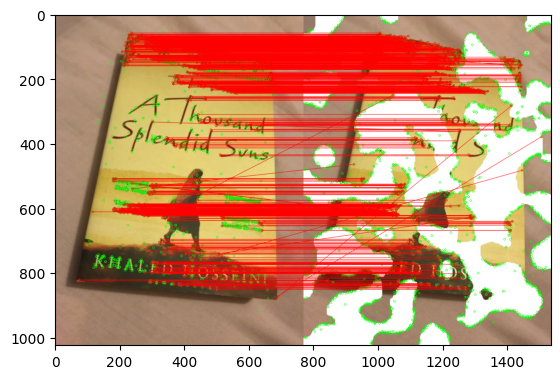

Match paires: 9, Keypoints in img1: 2342, Keypoints in img2: 1910
Matching score is: 0.47%


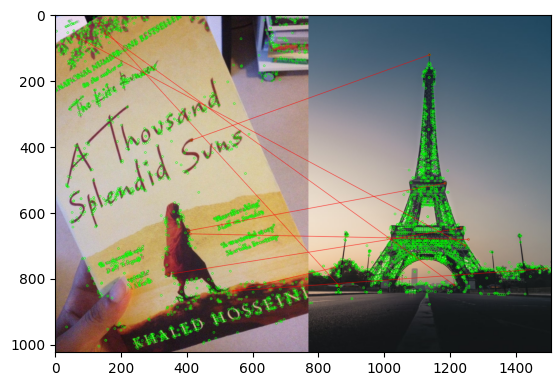

Match paires: 27, Keypoints in img1: 2342, Keypoints in img2: 1620
Matching score is: 1.67%


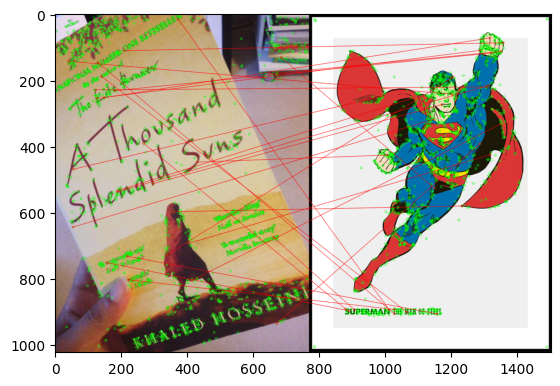

Match paires: 112, Keypoints in img1: 2342, Keypoints in img2: 3131
Matching score is: 4.78%


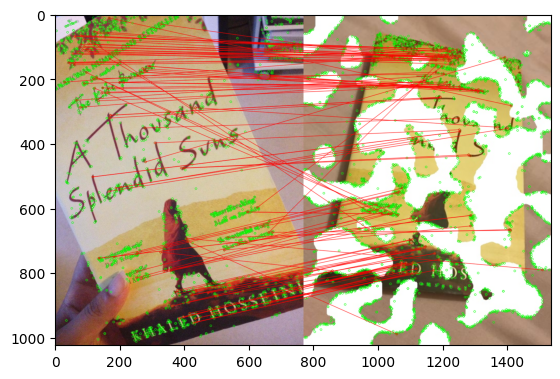

Match paires: 10, Keypoints in img1: 1910, Keypoints in img2: 1620
Matching score is: 0.62%


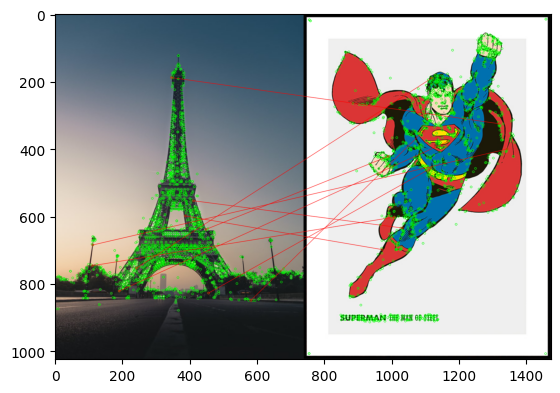

Match paires: 7, Keypoints in img1: 1910, Keypoints in img2: 3131
Matching score is: 0.37%


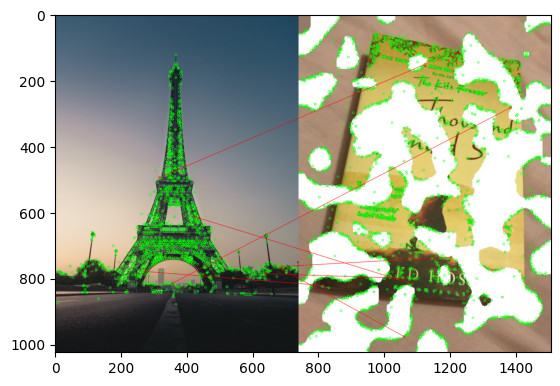

Match paires: 31, Keypoints in img1: 1620, Keypoints in img2: 3131
Matching score is: 1.91%


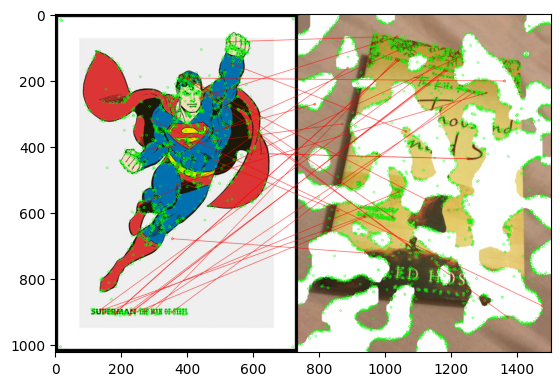

In [158]:
import cv2
import pickle
import matplotlib.pyplot as plt

def imageResizeTrain(image):
    maxD = 1024
    if image is None:
        print("Image not found or could not be loaded!")
        return None
    height, width = image.shape[:2]
    aspectRatio = width / height
    if aspectRatio < 1:
        newSize = (int(maxD * aspectRatio), maxD)
    else:
        newSize = (maxD, int(maxD / aspectRatio))
    image = cv2.resize(image, newSize)
    return image

def imageResizeTest(image):
    maxD = 1024
    if image is None:
        print("Image not found or could not be loaded!")
        return None
    height, width, channel = image.shape
    aspectRatio = width / height
    if aspectRatio < 1:
        newSize = (int(maxD * aspectRatio), maxD)
    else:
        newSize = (maxD, int(maxD / aspectRatio))
    image = cv2.resize(image, newSize)
    return image

# Load all images
imageList = ["./book1.jpg", "./book2.jpg", "./eiffel.jpg", "./superman.jpg", "./book1_masked.jpg"]

# Load images in grayscale with error checking
imagesBW = []
for imagePath in imageList:
    image = cv2.imread(imagePath, 0)  # flag 0 means grayscale
    if image is None:
        print(f"Error: Unable to load image {imagePath}")
        continue
    imagesBW.append(imageResizeTrain(image))

# Check if images were loaded correctly
if len(imagesBW) == 0:
    print("No images were successfully loaded. Exiting.")
else:
    print(f"{len(imagesBW)} images were loaded successfully.")

# Using SIFT to detect keypoints and descriptors
sift = cv2.SIFT_create()

def computeSIFT(image):
    return sift.detectAndCompute(image, None)

# Continue the rest of the process only if images were successfully loaded
if len(imagesBW) > 0:
    # Compute SIFT keypoints and descriptors for all images
    keypoints = []
    descriptors = []
    for i, image in enumerate(imagesBW):
        keypointTemp, descriptorTemp = computeSIFT(image)
        keypoints.append(keypointTemp)
        descriptors.append(descriptorTemp)

    # Store keypoints and descriptors for further use
    for i, keypoint in enumerate(keypoints):
        deserializedKeypoints = []
        filepath = str(imageList[i].split('/')[-1].split('.')[0]) + "_kps.txt"
        for point in keypoint:
            temp = (point.pt, point.size, point.angle, point.response, point.octave, point.class_id)
            deserializedKeypoints.append(temp)
        with open(filepath, 'wb') as fp:
            pickle.dump(deserializedKeypoints, fp)

    for i, descriptor in enumerate(descriptors):
        filepath = str(imageList[i].split('/')[-1].split('.')[0]) + "_feat.txt"
        with open(filepath, 'wb') as fp:
            pickle.dump(descriptor, fp)

# Check results for book1 vs book1_masked
bf = cv2.BFMatcher()
def calculateMatches(des1, des2):
    matches = bf.knnMatch(des1, des2, k=2)
    topResults1 = []
    for m, n in matches:
        if m.distance < 0.8 * n.distance:  # Using 0.8 threshold as per user suggestion
            topResults1.append([m])

    matches = bf.knnMatch(des2, des1, k=2)
    topResults2 = []
    for m, n in matches:
        if m.distance < 0.8 * n.distance:
            topResults2.append([m])

    topResults = []
    for match1 in topResults1:
        match1QueryIndex = match1[0].queryIdx
        match1TrainIndex = match1[0].trainIdx

        for match2 in topResults2:
            match2QueryIndex = match2[0].queryIdx
            match2TrainIndex = match2[0].trainIdx

            if (match1QueryIndex == match2TrainIndex) and (match1TrainIndex == match2QueryIndex):
                topResults.append(match1)
    return topResults

# Scoring function
def calculateScore(matches, keypoint1, keypoint2):
    return 100 * (matches / min(keypoint1, keypoint2))

# Drawing matched points
def getPlot(image1, image2, keypoint1, keypoint2, matches):
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    matchPlot = cv2.drawMatchesKnn(
        image1,
        keypoint1,
        image2,
        keypoint2,
        matches,
        None,
        matchColor=[255, 0, 0],
        singlePointColor=[0, 255, 0],
        flags=0
    )
    return matchPlot

def getPlotFor(i, j, keypoint1, keypoint2, matches):
    image1 = imageResizeTest(cv2.imread(imageList[i]))
    image2 = imageResizeTest(cv2.imread(imageList[j]))
    return getPlot(image1, image2, keypoint1, keypoint2, matches)

# Fetching results for any images
def fetchKeypointFromFile(i):
    filepath = str(imageList[i].split('/')[-1].split('.')[0]) + "_kps.txt"
    keypoint = []
    file = open(filepath, 'rb')
    deserializedKeypoints = pickle.load(file)
    file.close()
    for point in deserializedKeypoints:
        temp = cv2.KeyPoint(
            x=point[0][0],
            y=point[0][1],
            size=point[1],
            angle=point[2],
            response=point[3],
            octave=point[4],
            class_id=point[5]
        )
        keypoint.append(temp)
    return keypoint

def fetchDescriptorFromFile(i):
    filepath = str(imageList[i].split('/')[-1].split('.')[0]) + "_feat.txt"
    file = open(filepath, 'rb')
    descriptor = pickle.load(file)
    file.close()
    return descriptor

# Run comparison for all images pairwise and display results
for i in range(len(imageList)):
    for j in range(i + 1, len(imageList)):
        keypoint1 = fetchKeypointFromFile(i)
        descriptor1 = fetchDescriptorFromFile(i)
        keypoint2 = fetchKeypointFromFile(j)
        descriptor2 = fetchDescriptorFromFile(j)
        matches = calculateMatches(descriptor1, descriptor2)
        score = calculateScore(len(matches), len(keypoint1), len(keypoint2))
        
        # Display match information in the required format
        print(f"Match paires: {len(matches)}, Keypoints in img1: {len(keypoint1)}, Keypoints in img2: {len(keypoint2)}")
        print(f"Matching score is: {score:.2f}%")
        
        # Display match plot for this pair
        match_plot = getPlotFor(i, j, keypoint1, keypoint2, matches)
        plt.imshow(match_plot)
        plt.show()